In [1]:
import os
os.chdir("..")

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# import mplcyberpunk
# plt.style.use("cyberpunk")
# plt.style.use('bmh')
import seaborn as sns
plt.style.use("fivethirtyeight")
sns.set_style("whitegrid")
import random
plt.ioff()

from shell_data.dataset.dataset import get_train_val_test_subsets
import torch

In [3]:
train_subsets, val_subsets, test_subsets = get_train_val_test_subsets(
        "mnist")

In [4]:
train_dataset = torch.utils.data.ConcatDataset(train_subsets)
len(train_dataset)

54004

In [5]:
X = [x for x, y in train_dataset]
y = [y for x, y in train_dataset]
X = torch.stack(X)
y = torch.tensor(y)
X.shape, y.shape

(torch.Size([54004, 1, 28, 28]), torch.Size([54004]))

In [6]:
from sklearn.manifold import TSNE
import umap

# reducer = TSNE(n_components=2, init="pca", random_state=0, learning_rate='auto',
# )
reducer = umap.UMAP(n_neighbors=10)
def to_features(X):
    return X.view(X.size(0), -1)
reducer.fit(to_features(X))

2023-01-30 17:51:07.632410: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-30 17:51:08.065795: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-30 17:51:08.065842: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-30 17:51:08.065846: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

UMAP(n_neighbors=10, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [7]:
import time
import pandas as pd
from rich.logging import RichHandler
import logging
from lightning_lite.utilities.seed import seed_everything
from shell_data.dataset.dataset import get_train_val_test_subsets
import torch
import os
from shell_data.utils.config import (
    ShELLDataSharingConfig,
    DatasetConfig,
    TaskModelConfig,
    TrainingConfig,
    ExperienceReplayConfig,
    DataValuationConfig,
    RouterConfig,
    BoltzmanExplorationConfig,
)
from shell_data.utils.record import Record, snapshot_perf, snapshot_conf_mat
import numpy as np
from shell_data.shell_agent.shell_agent_classification import ShELLClassificationAgent
from itertools import combinations



os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
torch.use_deterministic_algorithms(True)
seed_everything(0)

dataset_name = "mnist"
train_subsets, val_subsets, test_subsets = get_train_val_test_subsets(
    dataset_name)

size = 256

if isinstance(size, int):
    print("size:", size)
else:
    print("avg size: ", sum(size.values()) / len(size))

num_cls_per_task = 4
n_agents = 2
num_task_per_life = 1
buffer_integration_size = 50000  # sample all!
batch_size = 32
routing_method = "random"

cfg = ShELLDataSharingConfig(
    n_agents=n_agents,
    dataset=DatasetConfig(
        name=dataset_name,
        train_size=size,
        # should val_size be the same as train_size?
        # val_size=min(size * 3, min([len(d) for d in val_subsets])),
        val_size=size//4,
        num_task_per_life=num_task_per_life,
        num_cls_per_task=num_cls_per_task,
    ),
    task_model=TaskModelConfig(
        name=dataset_name,
    ),
    training=TrainingConfig(
        n_epochs=200,
        batch_size=batch_size,
        patience=10,
    ),
    experience_replay=ExperienceReplayConfig(
        buffer_size=buffer_integration_size,
        # train_size=size // 2,
    ),
    data_valuation=DataValuationConfig(
        method="performance",  # control how the receiver perceives data and what to keep
    ),
    router=RouterConfig(
        strategy=routing_method,  # control how the sender decides which data point to send
        # num_batches=4,
        num_batches=1,
        # batch_size=32,  # sending half of the data
        batch_size=size * 4,  # sending half of the data
        estimator_task_model=TaskModelConfig(
            name=dataset_name,
        ),
        explore=BoltzmanExplorationConfig(
            num_slates=size * 4,
        ),
        n_heads=n_agents,
    ),
)

receiver = ShELLClassificationAgent(
    train_subsets, val_subsets, test_subsets, cfg)
sender = ShELLClassificationAgent(
    train_subsets, val_subsets, test_subsets, cfg)

INFO:lightning_lite.utilities.seed:Global seed set to 0


size: 256
train_size: 256, num_cls_per_task: 4
train_size: 256, num_cls_per_task: 4


In [8]:
target_class = [0, 1, 4, 9]

In [9]:
receiver.ll_dataset.perm = torch.tensor(target_class)
sender.ll_dataset.perm = torch.tensor(target_class)

In [10]:
receiver_train = receiver.ll_dataset.get_train_dataset(0)
sender_train = sender.ll_dataset.get_train_dataset(0)
receiver_val = receiver.ll_dataset.get_val_dataset(0)

In [11]:
X_receiver_train = torch.stack([x for x, y in receiver_train])
y_receiver_train = torch.tensor([y for x, y in receiver_train])

X_sender_train = torch.stack([x for x, y in sender_train])
y_sender_train = torch.tensor([y for x, y in sender_train])

X_receiver_val = torch.stack([x for x, y in receiver_val])
y_receiver_val = torch.tensor([y for x, y in receiver_val])


In [12]:
len(X_receiver_train), len(X_sender_train), len(X_receiver_val)

(1024, 1024, 256)

In [13]:
X_receiver_train_embed = reducer.transform(to_features(X_receiver_train))
X_sender_train_embed = reducer.transform(to_features(X_sender_train))
X_receiver_val_embed = reducer.transform(to_features(X_receiver_val))

<Figure size 640x480 with 0 Axes>

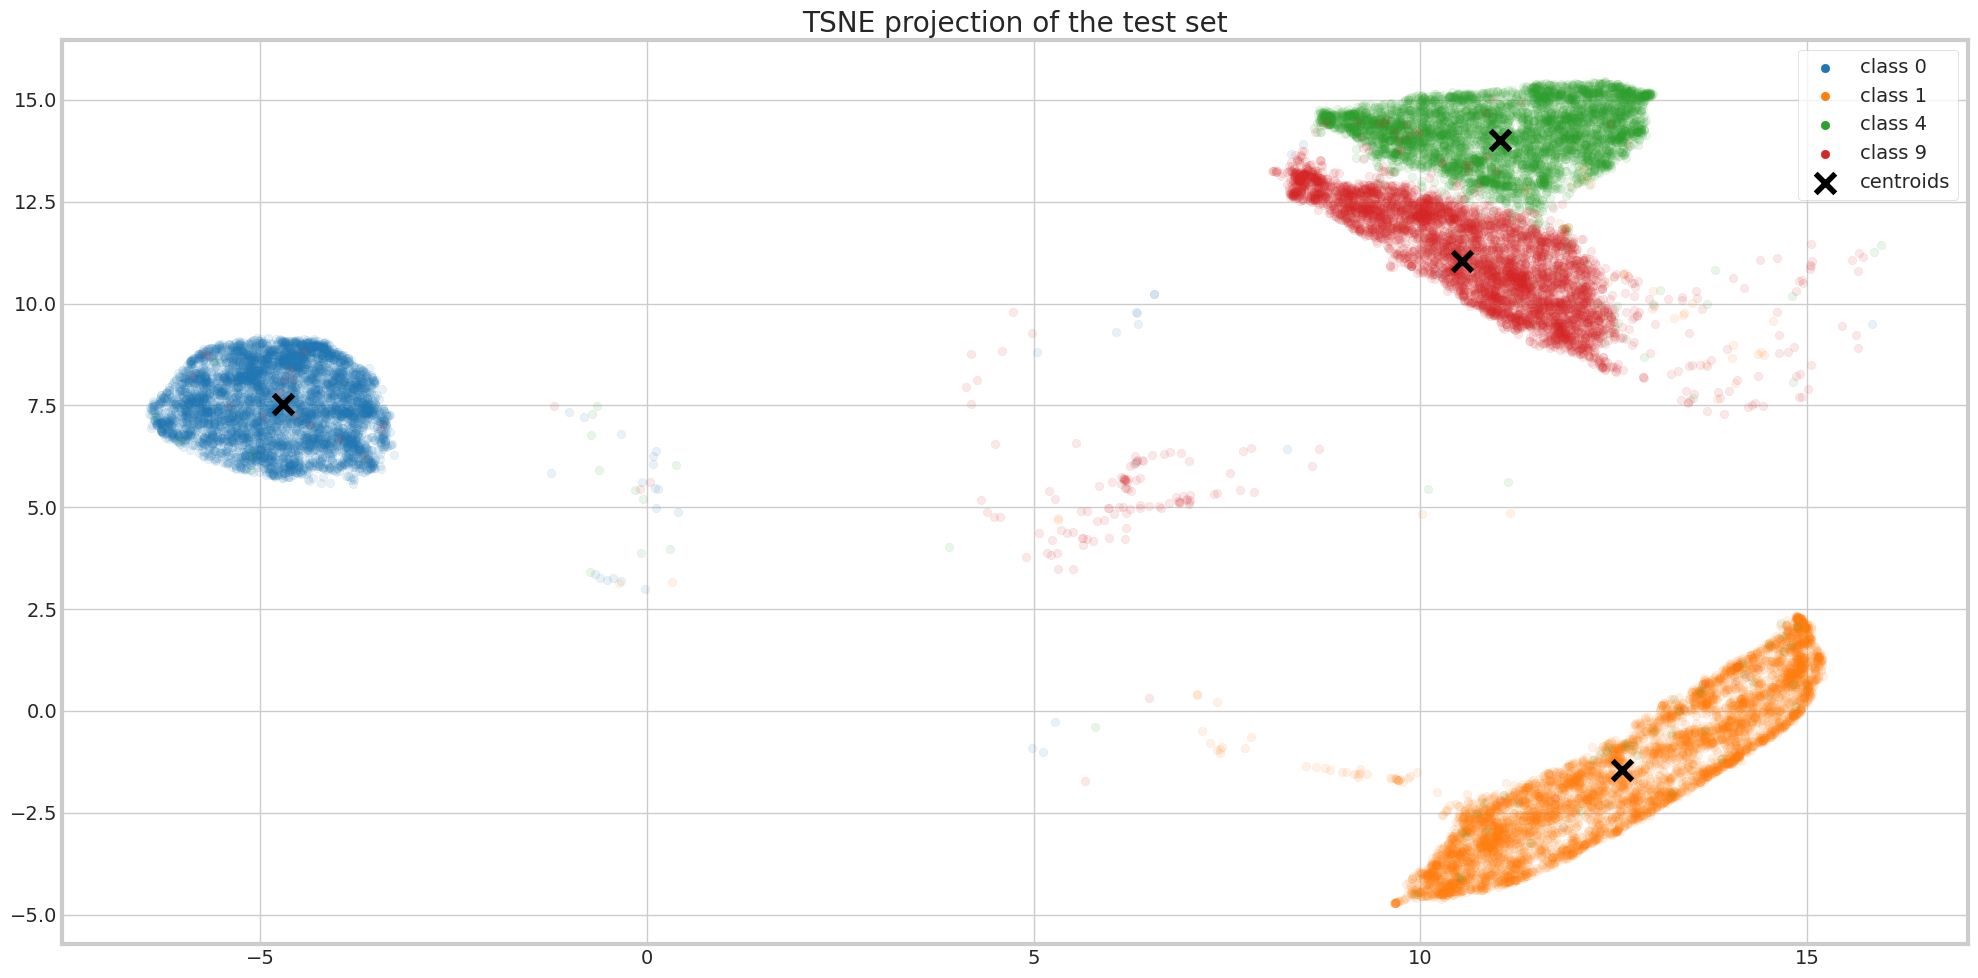

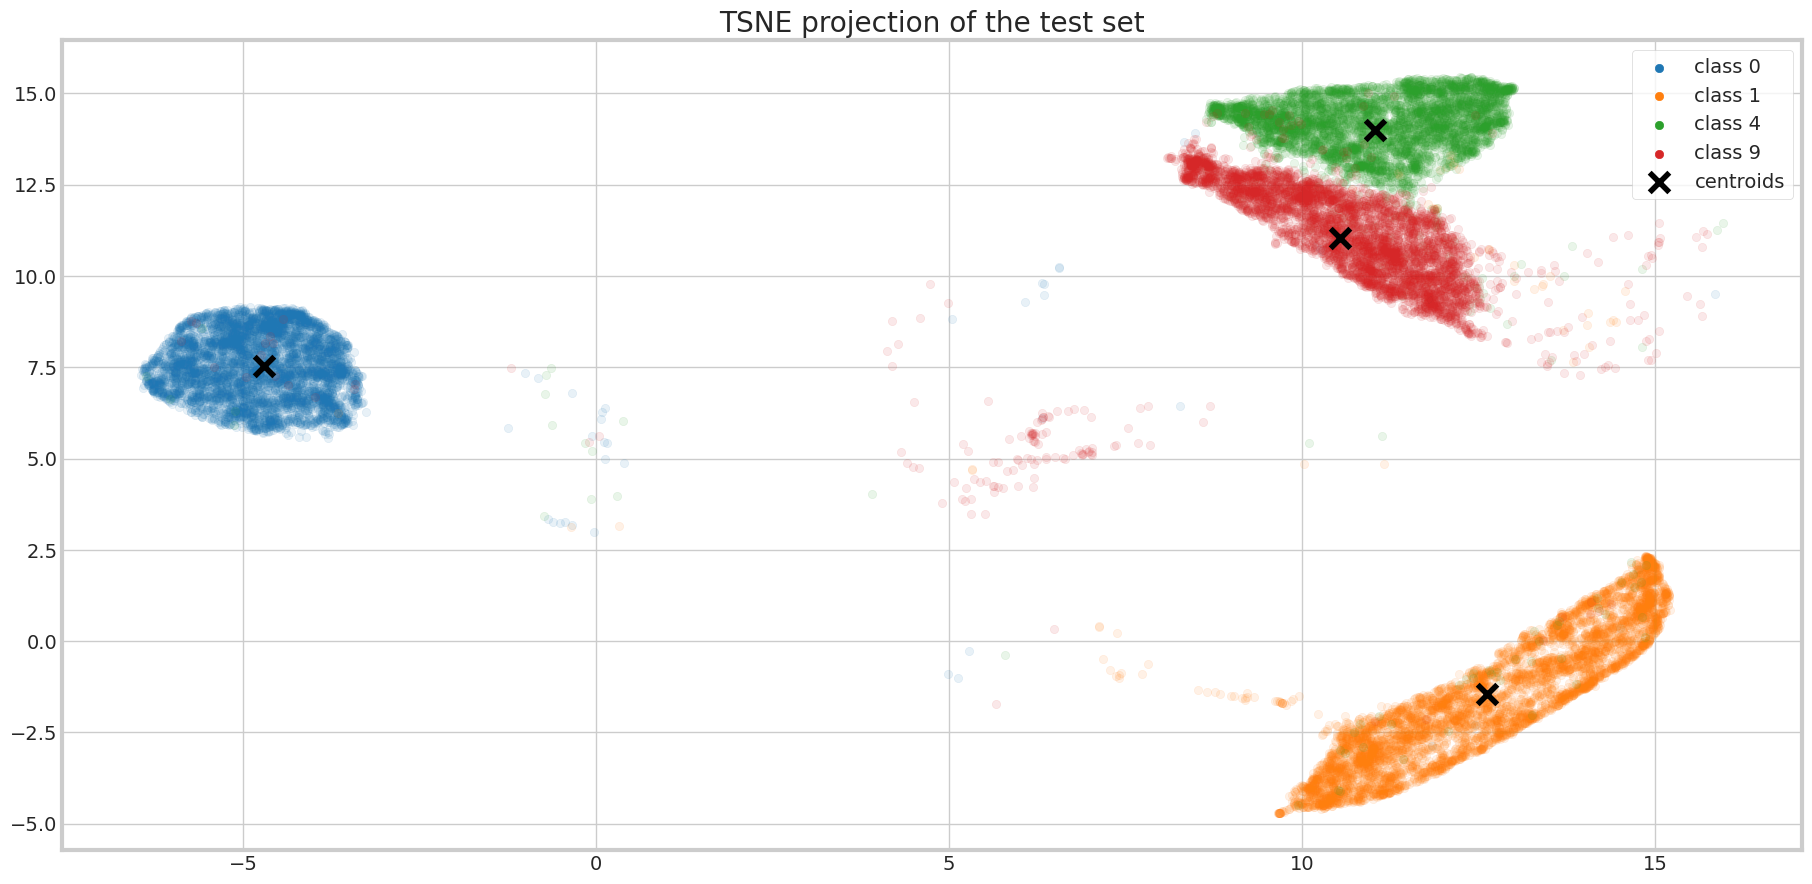

In [42]:
fig, ax = plt.subplots(figsize=(20, 10))

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]
centroids = []
# scatter with labels colored by class
for i in range(10):
    if i not in target_class:
        continue
    idx = (y== i).to("cpu")
    if idx.sum() < 1:
        continue
    color = colors.pop(0)

    ax.scatter(
    reducer.embedding_[idx, 0],
    reducer.embedding_[idx, 1],
    c=color,
    label=f"class {i}",
    alpha=0.1,
    marker='o',
    )    

    # ax.scatter(
    #     X_receiver_train_embed[y_receiver_train == i, 0],
    #     X_receiver_train_embed[y_receiver_train == i, 1],
    #     c=color,
    #     alpha=0.1,
    #     marker='*',
    #     s=100,
    # )

    # # ax.scatter(
    # #     X_receiver_val_embed[y_receiver_val == i, 0],
    # #     X_receiver_val_embed[y_receiver_val == i, 1],
    # #     c=color,
    # #     alpha=0.5,
    # #     marker='o',
    # #     s=100,
    # # )


    # ax.scatter(
    #     X_sender_train_embed[y_sender_train == i, 0],
    #     X_sender_train_embed[y_sender_train == i, 1],
    #     c=color,
    #     alpha=0.5,
    #     marker='x',
    #     s=10,
    # )


    # compute the centroid as the average of X
    centroids.append(reducer.embedding_[idx, :].mean(axis=0))

centroids = np.array(centroids)
# plot the centroids
ax.scatter(centroids[:, 0], centroids[:, 1], marker="x", c="black", s=200, label="centroids")


plt.title("TSNE projection of the test set")
# plot the decision boundary with the same color as the scatter
# display.plot(ax=ax, alpha=0.5, linewidth=2)
leg = ax.legend();
for lh in leg.legendHandles: 
    lh.set_alpha(1)

plt.show()
plt.tight_layout();

<Figure size 640x480 with 0 Axes>

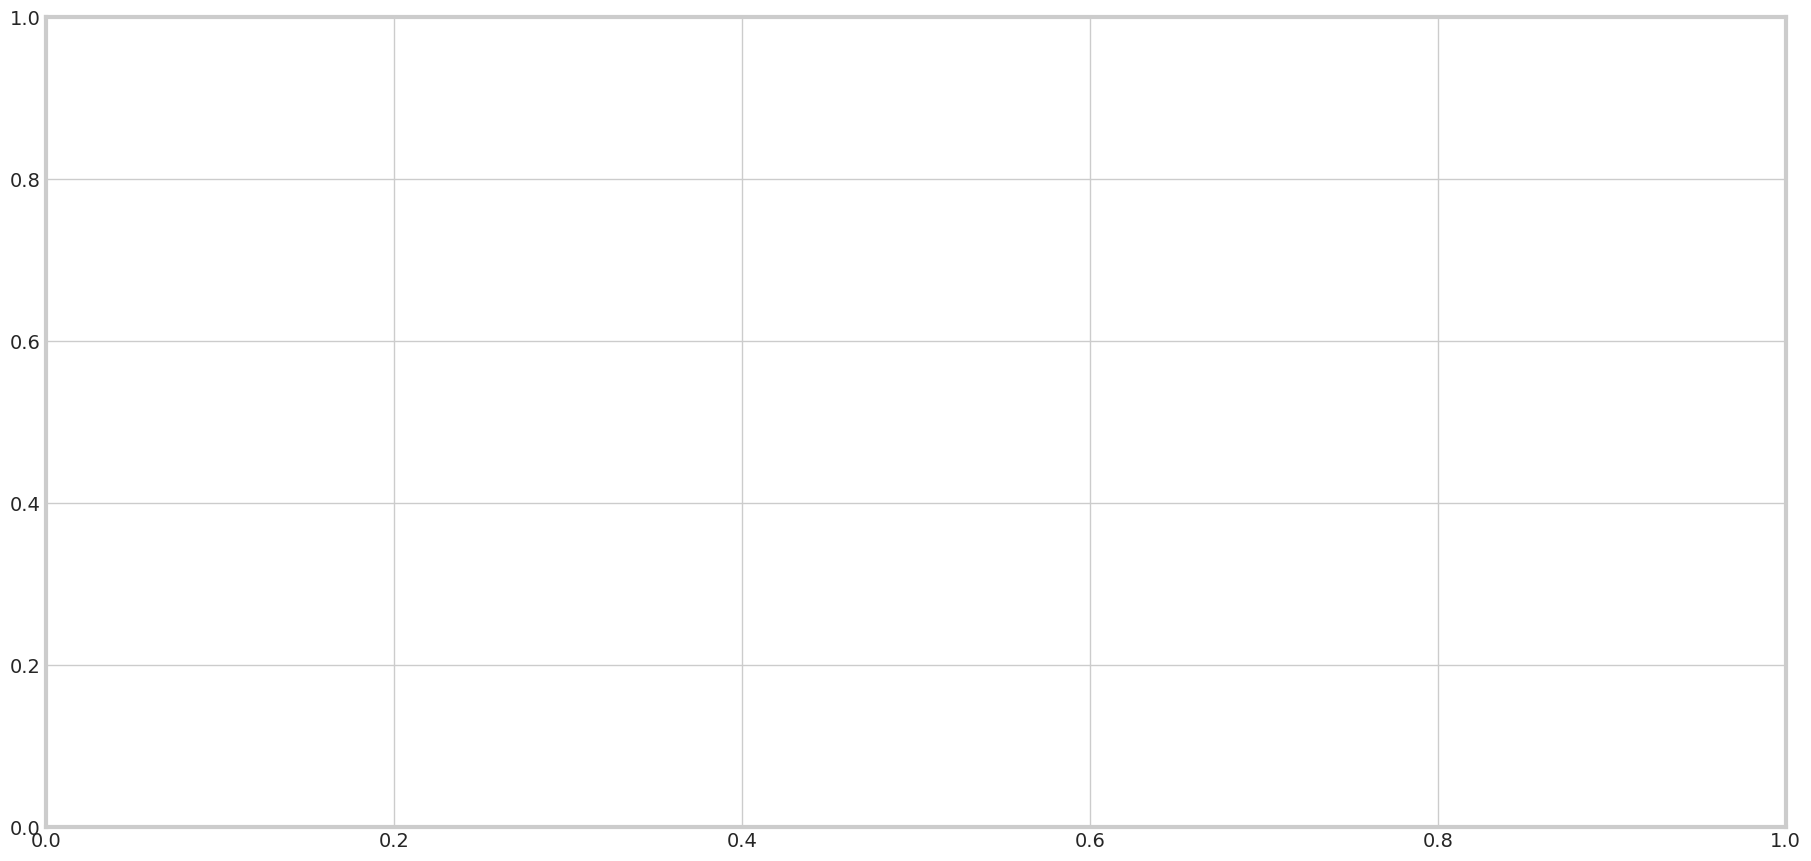

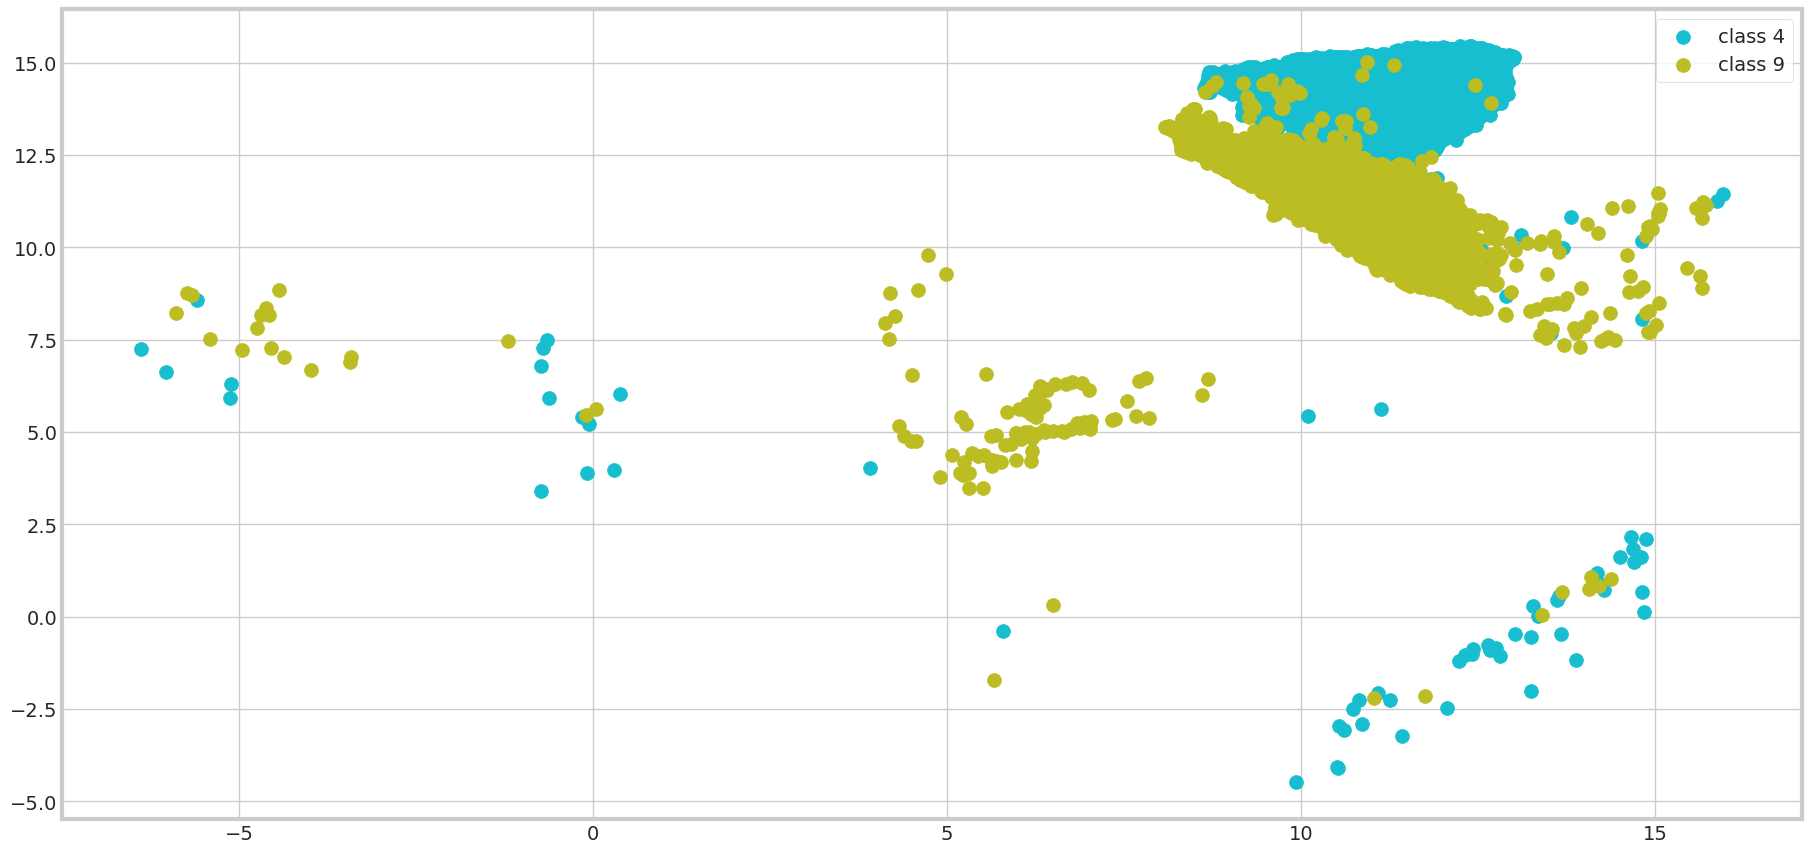

In [44]:
# plot the embedding of class 4 and 9
# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
fig, ax = plt.subplots(figsize=(20, 10))

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]
for i in range(10):
    if i not in [4, 9]:
        continue

    color = colors.pop(0)
    ax.scatter(
        reducer.embedding_[y == i, 0],
        reducer.embedding_[y == i, 1],
            label=f"class {i}",
            c=colors.pop(),
            # c=color,
            # alpha=0.1,
            # marker='*',
            s=100,
        )
plt.legend()
plt.show()
plt.tight_layout();

<Figure size 640x480 with 0 Axes>

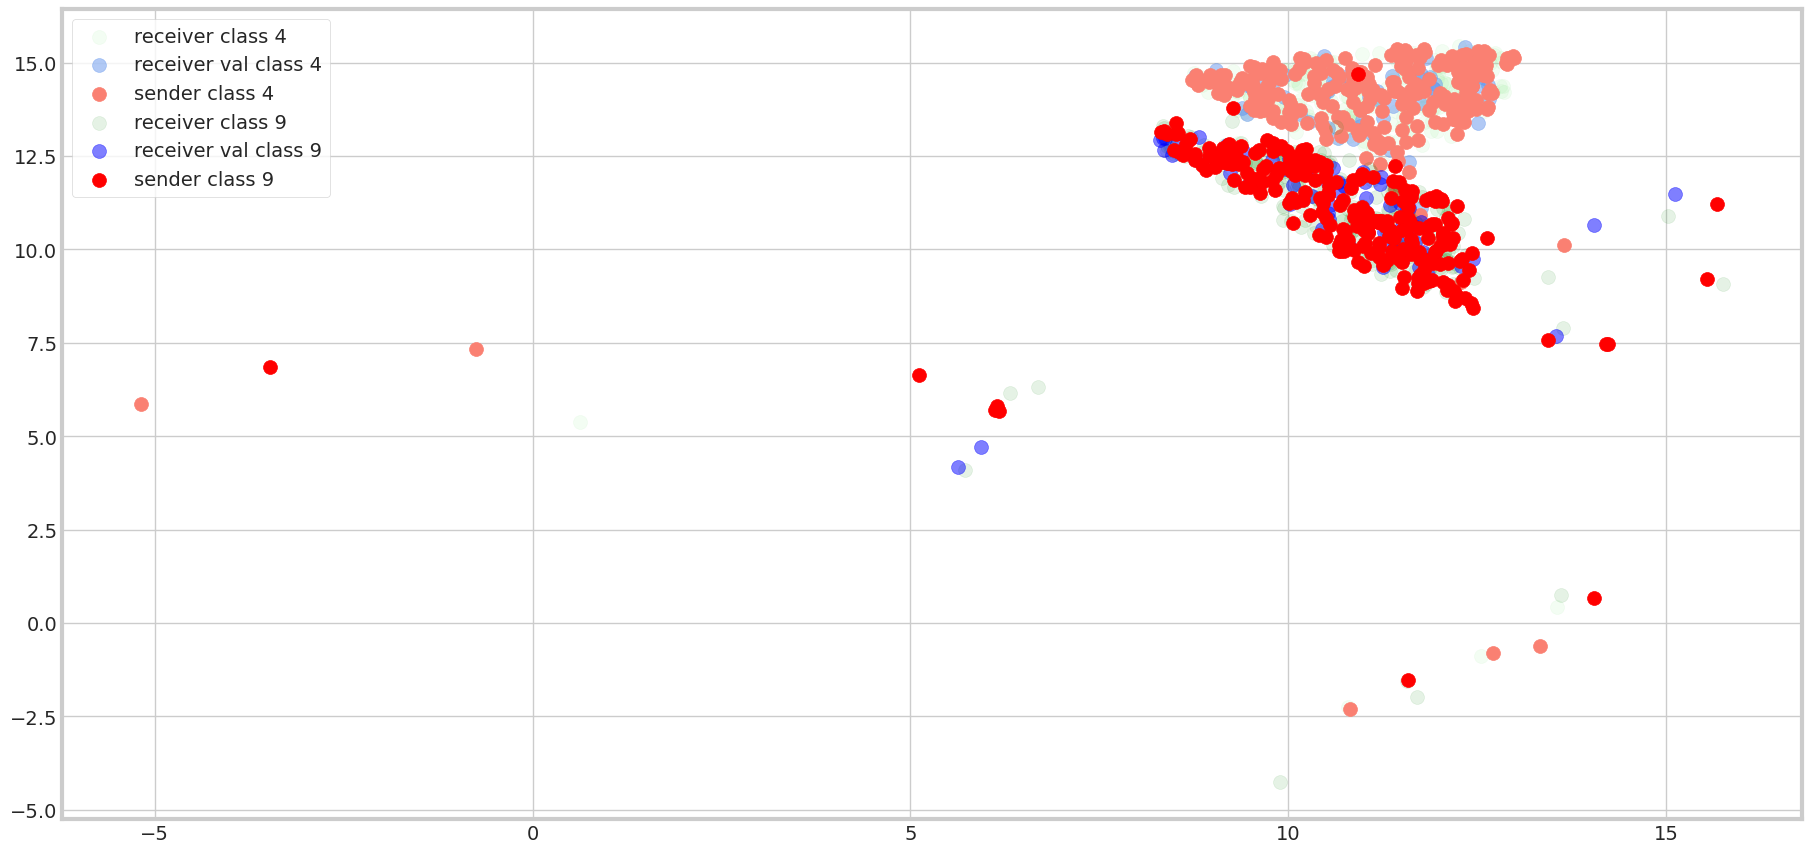

In [45]:
# plot the embedding of class 4 and 9
# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
fig, ax = plt.subplots(figsize=(20, 10))

val_colors = ['cornflowerblue', 'blue']
sender_train_colors = ['salmon', 'red']
receiver_train_colors = ['lightgreen', 'green']

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]
for i in range(10):
    if i not in [4, 9]:
        continue

    color = colors.pop(0)
    ax.scatter(
            X_receiver_train_embed[y_receiver_train == i, 0],
            X_receiver_train_embed[y_receiver_train == i, 1],
            label=f"receiver class {i}",
            c=receiver_train_colors.pop(0),
            # c=color,
            alpha=0.1,
            # marker='*',
            s=100,
        )

    ax.scatter(
            X_receiver_val_embed[y_receiver_val == i, 0],
            X_receiver_val_embed[y_receiver_val == i, 1],
            label=f"receiver val class {i}",
            c=val_colors.pop(0),
            # c=color,
            alpha=0.5,
            # marker='o',
            s=100,
        )


    ax.scatter(
            X_sender_train_embed[y_sender_train == i, 0],
            X_sender_train_embed[y_sender_train == i, 1],
            label=f"sender class {i}",
            c=sender_train_colors.pop(0),
            # c=color,
            # alpha=0.5,
            # marker='x',
            s=100,
        )

plt.legend()
plt.show()
plt.tight_layout();

In [16]:
# %matplotlib widget
# import matplotlib.widgets as widgets
# # visualization
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))


# idx = ((y == 4) | (y == 9)).cpu()
# scatter = ax[0].scatter(reducer.embedding_[idx, 0], reducer.embedding_[idx, 1], c=y[idx])
# ax[0].set_title('2D Embeddings with Labels')
# plt.colorbar(scatter)


# # when hover over a point, show the image
# def hover(event):
#     if event.inaxes == ax[0]:
#         cont, ind = scatter.contains(event)
#         if cont:
#             # draw the image
#             i = ind['ind'][0]
#             # display annot using X
#             img = X[idx][i].squeeze().numpy()
#             ax[1].imshow(img, cmap='gray')
#             # i = ind['ind'][0]
#             # ax.set_title(f'Label: {y[i]}')
#             # fig.canvas.draw_idle()

# fig.canvas.mpl_connect('motion_notify_event', hover)

In [17]:
# use sklearn KNN classifier to predict the class of X and compute the confusion matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(reducer.embedding_, y)
y_pred = knn.predict(reducer.embedding_)

print(confusion_matrix(y, y_pred))
print(f"Accuracy: {np.diag(confusion_matrix(y, y_pred)).sum() / len(y)}")

[[5289    4    3    0    1    7   18    1    1    7]
 [   1 6016   14    2   12    0    2   13    2    6]
 [  29   46 5155   25    6    3   13   73    6    7]
 [   5    9   28 5318    0   55    3   30   40   30]
 [   5   41    1    1 5100    0   10    7    2   91]
 [   8    8    3   51    6 4696   60    3   16   28]
 [  15    9    0    0    6   18 5278    0    1    0]
 [   2   58   21    2   10    1    0 5485    2   58]
 [  13   66   10   69   25   95   31    9 4886   62]
 [  15    9    2   50   54    9    3   62   18 5133]]
Accuracy: 0.969483741945041


In [18]:
y_pred = torch.tensor(y_pred)

In [19]:
# pick some misclassified examples and plot images, with the predicted and true labels
misclassified = (y != y_pred)
X_misclassified = X[misclassified]
y_misclassified = y[misclassified]
y_pred_misclassified = y_pred[misclassified]

n_samples = 10
fig, axes = plt.subplots(nrows=n_samples, ncols=1, figsize=(5, 20))
for i in range(n_samples):
    rand_idx = random.randint(0, len(X_misclassified))
    ax = axes[i]
    ax.imshow(X_misclassified[rand_idx].squeeze(), cmap="gray")
    ax.set_title(f"true: {y_misclassified[rand_idx]}, pred: {y_pred_misclassified[rand_idx]}")
    ax.axis("off")